# Mini Projet SSL for Anomaly Detection

In [1]:
# Imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms.functional import rgb_to_grayscale
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
import PIL
from PIL import Image
import random
import opendatasets as od
import os
from time import time
import multiprocessing as mp
import numpy as np
from pathlib import Path

In [ ]:
# Create a directory to store the datasets
os.makedirs("datasets", exist_ok=True)

mvtec_ad_url = "https://www.kaggle.com/datasets/ipythonx/mvtec-ad"
auto_vi_url = "https://zenodo.org/api/records/10459003/files-archive"

od.download(mvtec_ad_url, data_dir="datasets/MVTec_AD")

od.download(auto_vi_url, data_dir="datasets/AutoVI")
!unzip datasets/AutoVI/10459003.zip -d datasets/AutoVI
!unzip datasets/AutoVI/engine_wiring.zip -d datasets/AutoVI

### Global Variables

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRANSFORM = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MVTEC_PATH = 'datasets/MVTec_AD/mvtec-ad'
AUTOVI_PATH = 'datasets/AutoVI/engine_wiring'
CATEGORIES_MVTEC = ['bottle', 'hazelnut', 'capsule', 'toothbrush']
CATEGORIES_AUTOVI = ['blue_hoop', 'cardboard', 'fastening', 'obstruction']

### Chargement et prétraitement des images de MVTec AD

In [3]:
def load_mvtec_images(category, split='train'):
    images = []
    labels = []
    
    split_path = os.path.join(MVTEC_PATH, category, split)
    
    if split == 'train':
        good_path = os.path.join(split_path, 'good')
        for img_name in os.listdir(good_path):
            img_path = os.path.join(good_path, img_name)
            img = Image.open(img_path).convert('RGB')
            img = TRANSFORM(img)
            images.append(img)
            labels.append(0)
    
    else:
        for anomaly_type in os.listdir(split_path):
            anomaly_path = os.path.join(split_path, anomaly_type)
            for img_name in os.listdir(anomaly_path):
                img_path = os.path.join(anomaly_path, img_name)
                img = Image.open(img_path).convert('RGB')
                img = TRANSFORM(img)
                images.append(img)
                
                if anomaly_type == 'good':
                    labels.append(0)
                else:
                    labels.append(1)

    return torch.stack(images), torch.tensor(labels)

train_images, train_labels = [], []
test_images, test_labels = [], []

for category in CATEGORIES_MVTEC:
    imgs, lbls = load_mvtec_images(category, split='train')
    train_images.append(imgs)
    train_labels.append(lbls)
    
    imgs, lbls = load_mvtec_images(category, split='test')
    test_images.append(imgs)
    test_labels.append(lbls)

train_images = torch.cat(train_images)
train_labels = torch.cat(train_labels)
test_images = torch.cat(test_images)
test_labels = torch.cat(test_labels)

train_dataloader_MVTec = DataLoader(list(zip(train_images, train_labels)), batch_size=16, shuffle=True)
test_dataloader_MVTec = DataLoader(list(zip(test_images, test_labels)), batch_size=16, shuffle=False)

print(f"Loaded {len(train_images)} training images and {len(test_images)} test images from MVTec AD.")

Loaded 879 training images and 367 test images from MVTec AD.


### Chargement et prétraitement des images de AutoVI

In [4]:
# Function to load images from a specific split (train or test)
def load_autovi_images(split='train'):
    images = []
    labels = []
    
    # Define the path based on the split (train/test)
    split_path = os.path.join(AUTOVI_PATH, split)
    
    # List all subfolders (categories)
    categories = os.listdir(split_path)
    
    for category in categories:
        category_path = os.path.join(split_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path).convert('RGB')  
            img = TRANSFORM(img)  
            images.append(img)
            
            # Use the index of the category as a label (you can adjust this if needed)
            labels.append(categories.index(category))
    
    return torch.stack(images), torch.tensor(labels)  

# Load AutoVI dataset images (train and test)
train_images, train_labels = load_autovi_images(split='train')
test_images, test_labels = load_autovi_images(split='test')

# Create DataLoaders for AutoVI train and test sets
train_dataloader_auto = DataLoader(list(zip(train_images, train_labels)), batch_size=16, shuffle=True)
test_dataloader_auto = DataLoader(list(zip(test_images, test_labels)), batch_size=16, shuffle=False)

# Check loaded data
print(f"Loaded {len(train_images)} training images and {len(test_images)} test images from AutoVI.")

Loaded 285 training images and 607 test images from AutoVI.


### Visualisation

In [5]:
def denormalize(tensor):
    denormalized_tensor = tensor * 0.5 + 0.5
    return denormalized_tensor

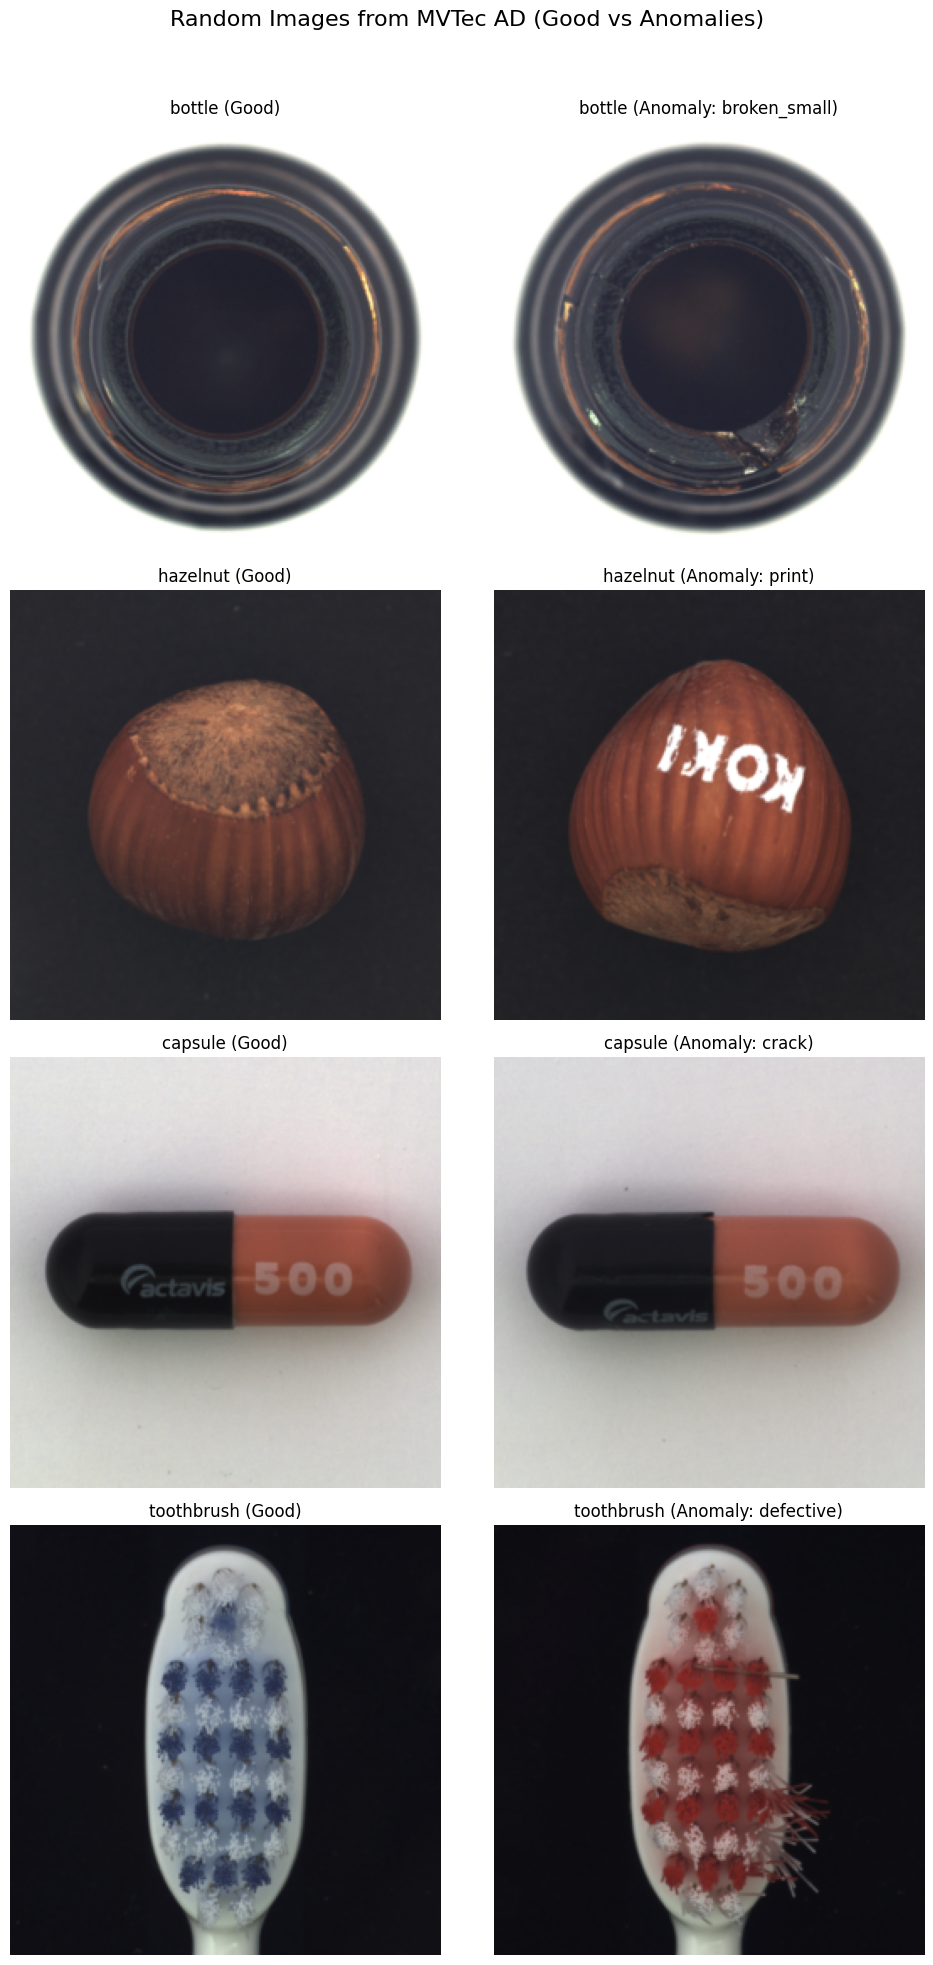

In [6]:
def display_random__MVTec(category_list, dataset_name, dataset_path, transform, split='test'):
    fig, axs = plt.subplots(len(category_list), 2, figsize=(10, 5 * len(category_list)))  
    fig.suptitle(f'Random Images from {dataset_name} (Good vs Anomalies)', fontsize=16)
    
    for i, category in enumerate(category_list):
        # Path for the test split
        split_path = os.path.join(dataset_path, category, split)
        
        # Load a random "good" image
        good_path = os.path.join(split_path, 'good')
        good_image = random.choice(os.listdir(good_path))
        good_image_path = os.path.join(good_path, good_image)
        img_good = Image.open(good_image_path).convert('RGB')
        img_good = transform(img_good)
        
        # Display the "good" image
        img_good = denormalize(img_good)
        axs[i, 0].imshow(np.clip(img_good.permute(1, 2, 0).numpy(), 0, 1))  # Convert to NumPy and clip
        axs[i, 0].set_title(f"{category} (Good)")
        axs[i, 0].axis('off')
        
        # Load a random anomalous image (choose a random anomaly type)
        anomalies = [d for d in os.listdir(split_path) if d != 'good']
        anomaly_type = random.choice(anomalies)
        anomaly_path = os.path.join(split_path, anomaly_type)
        anomaly_image = random.choice(os.listdir(anomaly_path))
        anomaly_image_path = os.path.join(anomaly_path, anomaly_image)
        img_anomalous = Image.open(anomaly_image_path).convert('RGB')
        img_anomalous = transform(img_anomalous)
        
        # Display the anomalous image
        img_anomalous = denormalize(img_anomalous)
        axs[i, 1].imshow(np.clip(img_anomalous.permute(1, 2, 0).numpy(), 0, 1))  # Convert to NumPy and clip
        axs[i, 1].set_title(f"{category} (Anomaly: {anomaly_type})")
        axs[i, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage for MVTec AD dataset
display_random__MVTec(CATEGORIES_MVTEC, "MVTec AD", MVTEC_PATH, TRANSFORM, split='test')

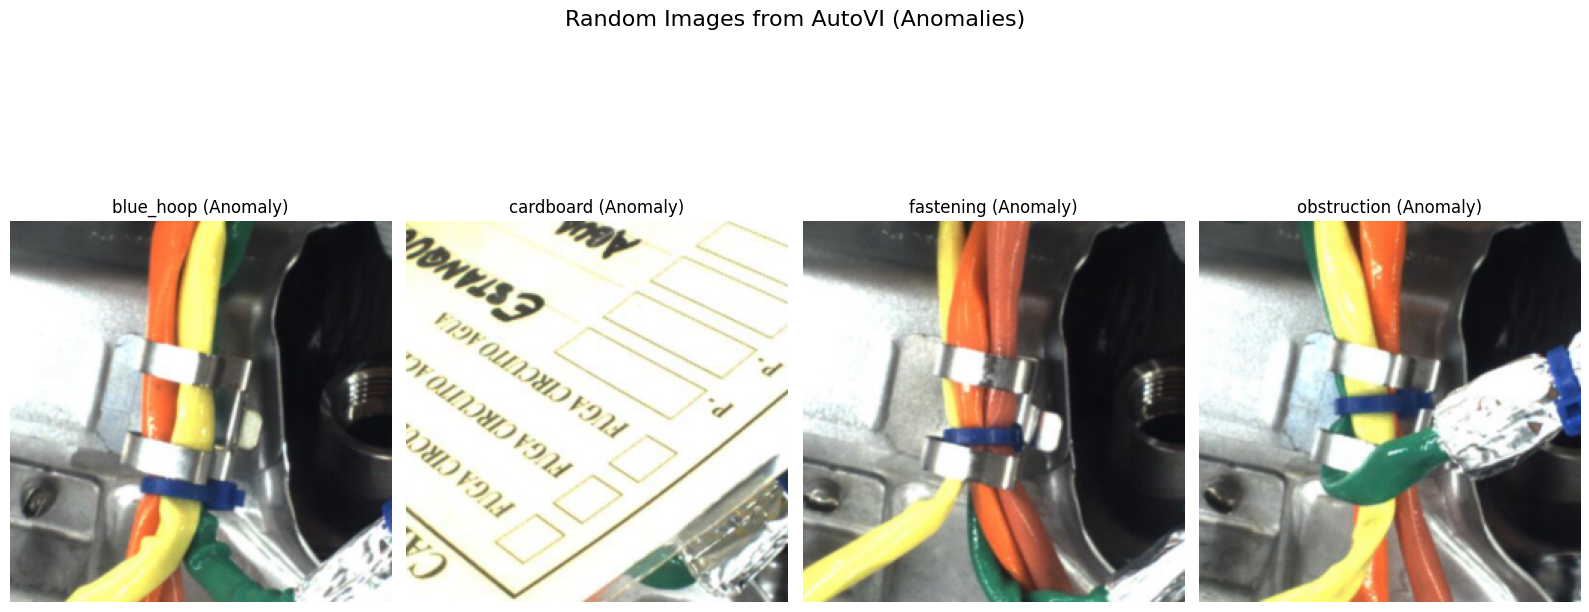

In [7]:
def display_random_autovi(category_list, dataset_name, dataset_path, transform, split='test'):
    fig, axs = plt.subplots(1, len(category_list), figsize=(16, 8))  # Create subplot (1 row, 1 column per category)
    fig.suptitle(f'Random Images from {dataset_name} (Anomalies)', fontsize=16)
    
    for i, category in enumerate(category_list):
        # Path for the test split
        split_path = os.path.join(dataset_path, split, category)
        
        # Load a random anomalous image
        anomaly_image = random.choice(os.listdir(split_path))
        anomaly_image_path = os.path.join(split_path, anomaly_image)
        img_anomalous = Image.open(anomaly_image_path).convert('RGB')
        img_anomalous = transform(img_anomalous)
        
        # Display the anomalous image
        img_anomalous = denormalize(img_anomalous)
        axs[i].imshow(np.clip(img_anomalous.permute(1, 2, 0).numpy(), 0, 1))  # Rearrange dimensions for display
        axs[i].set_title(f"{category} (Anomaly)")
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage for AutoVI dataset
display_random_autovi(CATEGORIES_AUTOVI, "AutoVI", AUTOVI_PATH, TRANSFORM, split='test')

### Masked AutoEncoder

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dim,in_channels):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, latent_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.encode(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_channels):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1), 
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

In [9]:
# Define the Masked Autoencoder model
class MaskedAutoencoder(nn.Module):
    def __init__(self, mask_ratio, hidden_dim=1024):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim=hidden_dim, in_channels=3)  # Input grayscale
        self.decoder = Decoder(latent_dim=hidden_dim, out_channels=3)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        masked_x = self.apply_mask(x)
        encoded = self.encoder(masked_x)
        decoded = self.decoder(encoded)
        return decoded.view(batch_size, channels, height, width)

    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)  
        x_masked[mask] = 0
        return x_masked


In [10]:
# Function to train the model
def train_model(model, dataloader, epochs, lr=0.001):
    criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for images, _ in tqdm(dataloader):
            images = images.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

# Function to evaluate the model and calculate ROC-AUC
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.MSELoss(reduction='none')  # Use reduction='none' to compute loss per pixel
    losses = []
    labels = []
    seuil = 0.5
    with torch.no_grad():
        for images, lbls in tqdm(dataloader):
            images = images.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, images).mean(dim=[1, 2, 3])  # Mean loss over pixels
            losses.extend(loss.cpu().numpy())
            binary_labels = [1 if label != 0 else 0 for label in lbls]
            labels.extend(binary_labels)
            
    # Appliquer le seuil pour classifier les images
    predicted_labels = [1 if loss > seuil else 0 for loss in losses]
    fpr, tpr, thresholds = roc_curve(labels, losses)

    accuracy = accuracy_score(labels, predicted_labels)
    print(f"Accuracy with threshold {seuil}: {accuracy:.4f}")
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Masked Autoencoder')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

100%|███████████████████████████████████████████████████████████████████████████████████| 55/55 [00:07<00:00,  7.19it/s]


Epoch [1/5], Loss: 0.4280


100%|███████████████████████████████████████████████████████████████████████████████████| 55/55 [00:07<00:00,  7.16it/s]


Epoch [2/5], Loss: 0.3079


100%|███████████████████████████████████████████████████████████████████████████████████| 55/55 [00:07<00:00,  7.16it/s]


Epoch [3/5], Loss: 0.2868


100%|███████████████████████████████████████████████████████████████████████████████████| 55/55 [00:07<00:00,  7.17it/s]


Epoch [4/5], Loss: 0.2857


100%|███████████████████████████████████████████████████████████████████████████████████| 55/55 [00:07<00:00,  7.17it/s]


Epoch [5/5], Loss: 0.2853


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 19.16it/s]


Accuracy with threshold 0.5: 0.3079


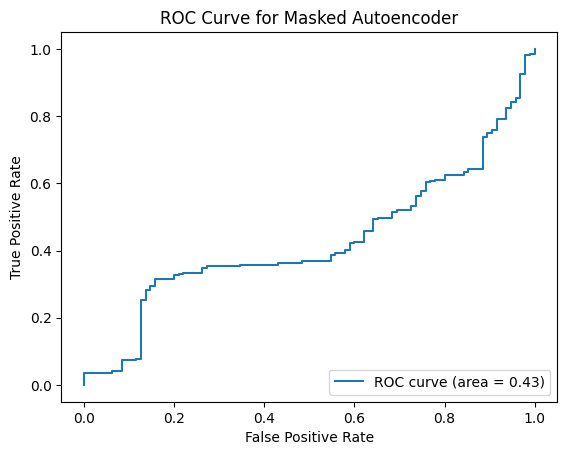

AUROC Score: 0.4276


In [11]:
# Assuming train_dataloader_MVTec and test_dataloader_MVTec are defined
# Initialize and train the model
mae_model_MV = MaskedAutoencoder(mask_ratio = 1/5).to(DEVICE)
train_model(mae_model_MV, train_dataloader_MVTec, epochs=5)
torch.save(mae_model_MV.state_dict(), 'Masked_Autoencoder_MVTec_weights.pth')

# Evaluate the model
roc_auc = evaluate_model(mae_model_MV, test_dataloader_MVTec)
print(f"AUROC Score: {roc_auc:.4f}")

100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.19it/s]


Epoch [1/5], Loss: 0.4478


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.23it/s]


Epoch [2/5], Loss: 0.3186


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.23it/s]


Epoch [3/5], Loss: 0.2822


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.22it/s]


Epoch [4/5], Loss: 0.2587


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.23it/s]


Epoch [5/5], Loss: 0.2464


100%|███████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 19.65it/s]


Accuracy with threshold 0.5: 0.0033


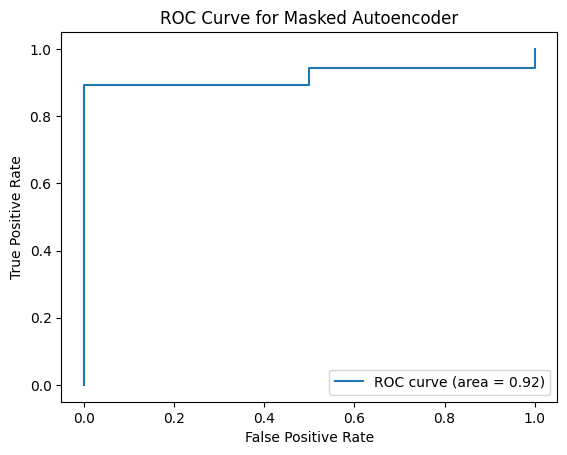

AUROC Score: 0.9182


In [12]:
# Assuming train_dataloader_MVTec and test_dataloader_MVTec are defined
# Initialize and train the model
mae_model_auto = MaskedAutoencoder(mask_ratio = 1/5).to(DEVICE)
train_model(mae_model_auto, train_dataloader_auto, epochs=5)
torch.save(mae_model_auto.state_dict(), 'Masked_Autoencoder_AUTO_weights.pth')

# Evaluate the model
roc_aucs = evaluate_model(mae_model_auto, test_dataloader_auto)
print(f"AUROC Score: {roc_aucs:.4f}")

### Contrastive Model

In [13]:
class ContrastiveModel(nn.Module):
    def __init__(self):
        super(ContrastiveModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=1)
        )
        self.fc = nn.Linear(64 * 27 * 27, 64)  # Ajusté en fonction de la sortie des convolutions

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir les données
        x = self.fc(x)
        return x


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, z1, z2, label):
        euclidean_distance = nn.functional.pairwise_distance(z1, z2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + 
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

In [14]:
def generate_contrastive_pairs(batch_images, batch_labels):
    pairs = []
    pair_labels = []
    
    batch_size = len(batch_images)
    
    for i in range(batch_size):
        # Générer une paire positive (même classe)
        positive_indices = [j for j in range(batch_size) if batch_labels[i] == batch_labels[j]]
        if len(positive_indices) > 1:  # Vérifier qu'il y a au moins une autre image de la même classe
            positive_index = random.choice([j for j in positive_indices if j != i])
            pairs.append((batch_images[i], batch_images[positive_index]))
            pair_labels.append(1)  # Label 1 pour paire positive
        
        # Générer une paire négative (classe différente)
        negative_indices = [j for j in range(batch_size) if batch_labels[i] != batch_labels[j]]
        if len(negative_indices) > 0:  # Vérifier qu'il y a au moins une image d'une classe différente
            negative_index = random.choice(negative_indices)
            pairs.append((batch_images[i], batch_images[negative_index]))
            pair_labels.append(0)  # Label 0 pour paire négative

    # Convertir en tenseurs
    if pairs:  # Vérifier si des paires ont été générées
        pair1, pair2 = zip(*pairs)
        return (torch.stack(pair1), torch.stack(pair2)), torch.tensor(pair_labels)
    else:
        raise ValueError("Aucune paire n'a pu être générée dans ce batch.")

In [15]:
# Fonction d'entraînement pour le modèle contrastif
def train_contrastive_model(model, dataloader, epochs, lr=0.001, weight_decay=1e-4, patience=2):
    criterion = nn.CosineEmbeddingLoss()  # Utilise la perte de similarité cosinus
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for batch_images, batch_labels in tqdm(dataloader):
            batch_images = batch_images.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)

            # Générer des paires contrastives
            pairs, pair_labels = generate_contrastive_pairs(batch_images, batch_labels)

            # Obtenir les représentations latentes des deux images dans la paire
            z1 = model(pairs[0].to(DEVICE))  # Appliquer .to(device) à chaque image
            z2 = model(pairs[1].to(DEVICE))

            optimizer.zero_grad()

            # Calculer la perte contrastive (CosineEmbeddingLoss)
            loss = criterion(z1, z2, pair_labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_images.size(0)
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        # Early Stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch+1}")
            break

In [16]:
def evaluate_contrastive_model(model, dataloader):
    model.eval()
    distances = []
    labels = []
    with torch.no_grad():
        for batch_images, batch_labels in tqdm(dataloader):
            pairs, pair_labels = generate_contrastive_pairs(batch_images, batch_labels)
            z1 = model(pairs[0].to(DEVICE))
            z2 = model(pairs[1].to(DEVICE))
            euclidean_distance = nn.functional.pairwise_distance(z1, z2)
            distances.extend(euclidean_distance.cpu().numpy())
            labels.extend(pair_labels.cpu().numpy())
    
    fpr, tpr, thresholds = roc_curve(labels, distances)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Contrastive Model')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

100%|███████████████████████████████████████████████████████████████████████████████████| 55/55 [00:03<00:00, 14.62it/s]


Epoch [1/2], Loss: 0.0451


100%|███████████████████████████████████████████████████████████████████████████████████| 55/55 [00:03<00:00, 14.26it/s]


Epoch [2/2], Loss: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 47.79it/s]


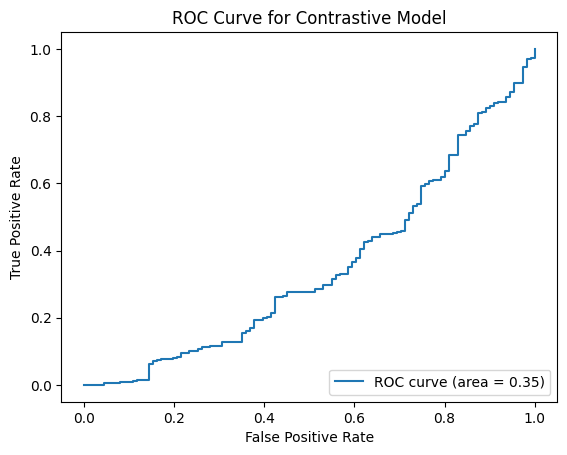

AUROC Score: 0.3492


In [17]:
contrastive_model = ContrastiveModel().to(DEVICE)
train_contrastive_model(contrastive_model, train_dataloader_MVTec, epochs=2)

roc_auc_score = evaluate_contrastive_model(contrastive_model, test_dataloader_MVTec)
print(f"AUROC Score: {roc_auc_score:.4f}")

## Colorizing task

### Build datasets

In [18]:
## Other way to load data --> Choose together which one to keep
class MVTECDataset(Dataset):
    def __init__(self, data_dir="datasets/MVTec_AD/mvtec-ad", split="train", transform=TRANSFORM):
        self.data_dir = Path(data_dir)
        self.image_paths = []
        self.split = split
        self.transform = transform
        
        for folder in self.data_dir.iterdir():
            if folder.is_dir():
                folder_path = folder / self.split / "good"
                self.image_paths.extend(folder_path.rglob("*.png"))
            
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        label = 1 if "anomaly" in img_path.stem.lower() else 0
        return image, label

### How to choose the right number of workers ?

In [ ]:
# Find the right number of workers
dataset = MVTECDataset()
for num_workers in range(2, mp.cpu_count(), 2):  
    train_loader = DataLoader(dataset, shuffle=False, num_workers=num_workers, batch_size=32, pin_memory=True)
    start = time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader, 0):
            pass
    end = time()
    print("Finish with: {} seconds, num_workers={}".format(end - start, num_workers))

### Build dataloaders

In [ ]:
train_dataset_MVTEC = MVTECDataset()
print(f"Train dataset size: {len(train_dataset_MVTEC)}")

test_dataset_MVTEC = MVTECDataset(split="test")
print(f"Test dataset size: {len(test_dataset_MVTEC)}")

train_loader_MVTEC = DataLoader(train_dataset_MVTEC, batch_size=32, shuffle=True, num_workers=8)
test_loader_MVTEC = DataLoader(test_dataset_MVTEC, batch_size=1, shuffle=False, num_workers=8)

### Build UNet

In [ ]:
## Lets choose a Unet to perform this task

def double_conv(in_channels, out_channels):
    # returns a block composed of two Convolution layers with ReLU activation function
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )   

class DownSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x_skip = self.conv_block(x) # output after convolutions to be used for skip connection
        out = self.maxpool(x_skip)  # output after maxpooling for downsampling

        return out, x_skip

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = double_conv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, x_skip):
        x = self.upsample(x)
        x = torch.cat([x, x_skip], dim=1) # concatenate the upsampled output with skip connection
        x = self.conv_block(x)

        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Define downsampling blocks
        self.downsample_block_1 = DownSampleBlock(1, 32)
        self.downsample_block_2 = DownSampleBlock(32, 64)
        self.downsample_block_3 = DownSampleBlock(64, 128)
        self.middle_conv_block = double_conv(128, 256)  # Middle convolution block

        # Define upsampling blocks
        self.upsample_block_3 = UpSampleBlock(256 + 128, 128)
        self.upsample_block_2 = UpSampleBlock(128 + 64, 64)
        self.upsample_block_1 = UpSampleBlock(64 + 32, 32)

        # Final output layer
        self.last_conv = nn.Conv2d(32, 3, 1)

    def forward(self, x):
        # Convert to gray image
        x = rgb_to_grayscale(x, num_output_channels=1)
        
        # Downsampling path
        x, x_skip1 = self.downsample_block_1(x)
        x, x_skip2 = self.downsample_block_2(x)
        x, x_skip3 = self.downsample_block_3(x)

        # Middle block
        x = self.middle_conv_block(x)

        # Upsampling path with skip connections
        x = self.upsample_block_3(x, x_skip3)
        x = self.upsample_block_2(x, x_skip2)
        x = self.upsample_block_1(x, x_skip1)

        # Final output layer with sigmoid activation
        out = torch.sigmoid(self.last_conv(x))

        return out

### Training part

In [ ]:
unet = UNet().to(DEVICE)
train_model(model=unet, dataloader=train_loader_MVTEC, epochs=5)

### Evaluate the model - TO BE DONE